In [33]:
# import os
# import shutil
#
# import tensorflow as tf
# import tensorflow_hub as hub
# import tensorflow_text as text
# from official.nlp import optimization  # to create AdamW optimizer
#
# import matplotlib.pyplot as plt
#
# tf.get_logger().setLevel('ERROR')

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from textblob import TextBlob
from nltk.stem import PorterStemmer,SnowballStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from io import StringIO
import os
import string
import gensim
from gensim.models import Word2Vec
import itertools
import scipy
from scipy import spatial
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
tokenizer = ToktokTokenizer()
# stopword_list = nltk.corpus.stopwords.words('english')   
stopword_list = nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /opt/app-
[nltk_data]     root/src/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !pip install textblob nltk gensim wordcloud

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /opt/app-
[nltk_data]     root/src/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /opt/app-
[nltk_data]     root/src/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
df = pd.read_csv("consumer_complaints.csv")
# df = df[:50000]

In [7]:
df.head()


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [8]:
df.dtypes


date_received                   object
product                         object
sub_product                     object
issue                           object
sub_issue                       object
consumer_complaint_narrative    object
company_public_response         object
company                         object
state                           object
zipcode                         object
tags                            object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
complaint_id                     int64
dtype: object

In [9]:
df.describe(include='all')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
count,555957,555957,397635,555957,212622,66806,85124,555957,551070,551452,77959,123458,555957,555957,555957,555957,555957,5.559570e+05
unique,1608,11,46,95,68,65646,10,3605,62,27052,3,4,6,1557,8,2,2,NaN
top,08/27/2015,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",Account status,This company continues to report on my credit ...,Company chooses not to provide a public response,Bank of America,CA,300XX,Older American,Consent provided,Web,11/13/2015,Closed with explanation,Yes,No,NaN
freq,963,186475,74319,97191,26798,37,52478,55998,81700,1205,45257,66807,361338,1108,404293,541909,443823,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.600510e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.504296e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.863230e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.737830e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.441702e+06


In [10]:
df.isnull().sum()/df.shape[0]*100


date_received                    0.000000
product                          0.000000
sub_product                     28.477382
issue                            0.000000
sub_issue                       61.755675
consumer_complaint_narrative    87.983603
company_public_response         84.688744
company                          0.000000
state                            0.879025
zipcode                          0.810314
tags                            85.977513
consumer_consent_provided       77.793606
submitted_via                    0.000000
date_sent_to_company             0.000000
company_response_to_consumer     0.000000
timely_response                  0.000000
consumer_disputed?               0.000000
complaint_id                     0.000000
dtype: float64

In [11]:
df1 = df[['complaint_id','date_received','product','issue','company','state','submitted_via','company_response_to_consumer','timely_response','consumer_disputed?','consumer_complaint_narrative']]


In [12]:
df1 = df1[pd.notnull(df1['consumer_complaint_narrative'])]
df1 =  df1[:2000]

## EDA
We’ll check the disribution of complaints by product category to understand which product received maximum complaints and 

other products which rarely receive complaints.



<AxesSubplot:xlabel='product', ylabel='count'>

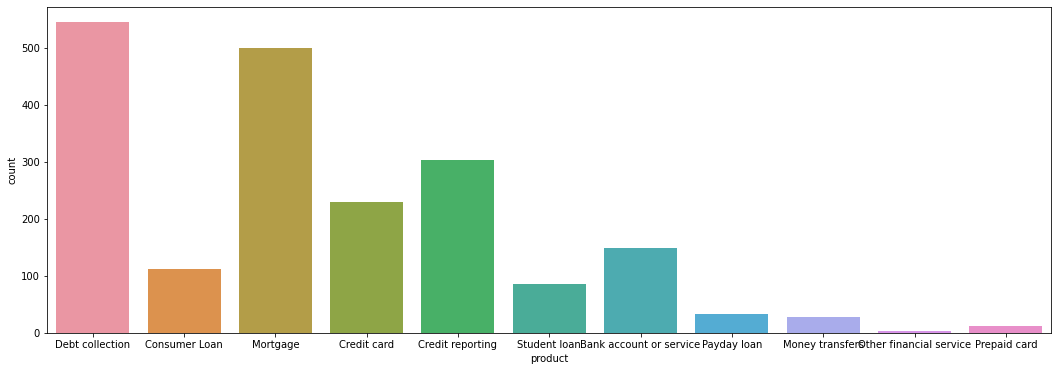

In [13]:
fig,ax = plt.subplots(figsize=(18,6))
sns.countplot(x='product',data=df1)

From this plot we can see Debt Collection and Mortgage received maximum number of complaints

We’ll now analyze the contingency table in form of plot to understand which product has more customer disputes on their complaints after resolving the issues

<AxesSubplot:xlabel='product'>

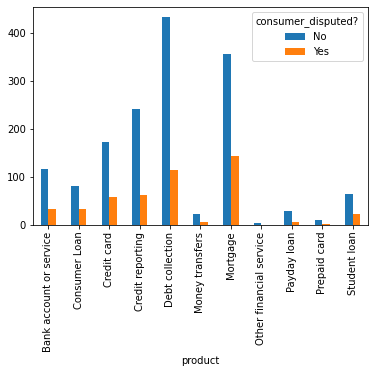

In [14]:
pd.crosstab(df1['product'],df1['consumer_disputed?']).plot(kind='bar')


Not much of difference in proportion of disputes raised by complaint for each product category.

Checking various plots to identify patterns within data

In [15]:
df1['date_received'] = pd.to_datetime(df1['date_received'])
df1.date_received.min(),df1.date_received.max()


(Timestamp('2015-03-19 00:00:00'), Timestamp('2015-05-11 00:00:00'))

<AxesSubplot:xlabel='month', ylabel='count'>

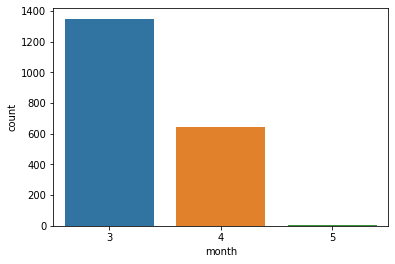

In [16]:
df1['month'] = df1['date_received'].dt.month
sns.countplot(x='month',data=df1)

<AxesSubplot:xlabel='timely_response', ylabel='count'>

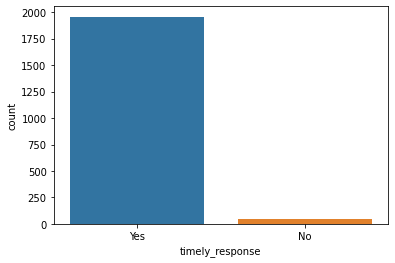

In [17]:
sns.countplot(x='timely_response',data=df1)


# Text Data Preprocessing


## Converting Text data to Lowercase


In [18]:
df1['consumer_complaint_narrative'] =df1['consumer_complaint_narrative'].apply(lambda x: ' '.join([i.lower() for i in x.split()]))
df1['consumer_complaint_narrative'].sample(2)



204178    i sold my townhouse at xxxx wi. it was suppose...
207681    attended university of xxxx for two years. the...
Name: consumer_complaint_narrative, dtype: object

## Removing Punctuations


In [19]:
df1['consumer_complaint_narrative'] =df1['consumer_complaint_narrative'].str.replace(r'[^\w\s]',"")
df1['consumer_complaint_narrative'].sample(2)


202245    i disputed my former mortgage with xxxx xxxx x...
201256    i signed up for a barclay xxxx credit card the...
Name: consumer_complaint_narrative, dtype: object

## Text standardization


In [20]:
# #Below, we used three normalizazion dictionaries from these links :
# #http://www.hlt.utdallas.edu/~yangl/data/Text_Norm_Data_Release_Fei_Liu/
# #http://people.eng.unimelb.edu.au/tbaldwin/etc/emnlp2012-lexnorm.tgz
# #http://luululu.com/tweet/typo-corpus-r1.txt
dico = {}
dico1 = open('doc1.txt', 'rb')
for word in dico1:
    word = word.decode('utf8')
    word = word.split()
    dico[word[1]] = word[3]
dico1.close()
dico2 = open('doc2.txt', 'rb')
for word in dico2:
    word = word.decode('utf8')
    word = word.split()
    dico[word[0]] = word[1]
dico2.close()
dico3 = open('doc3.txt', 'rb')
for word in dico3:
    word = word.decode('utf8')
    word = word.split()
    dico[word[0]] = word[1]
dico3.close()

In [21]:
def txt_std(words):
    list_words = words.split()
    for i in range(len(list_words)):
        if list_words[i] in dico.keys():
            list_words[i] = dico[list_words[i]]
    return ' '.join(list_words)

In [22]:
df1['consumer_complaint_narrative'] = df1['consumer_complaint_narrative'].apply(txt_std)
df1.consumer_complaint_narrative.head(1)


190126    xxxx has claimed i owe them 2700 for xxxx year...
Name: consumer_complaint_narrative, dtype: object

In [23]:

df1['consumer_complaint_narrative'] = df1['consumer_complaint_narrative'].str.replace(r"xx+\s","")
df1['consumer_complaint_narrative'].head(1)


190126    has claimed i owe them 2700 for years despite ...
Name: consumer_complaint_narrative, dtype: object

## Removing Stopwords


In [24]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df1['consumer_complaint_narrative'] =df1['consumer_complaint_narrative'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop]))
df1['consumer_complaint_narrative'].head(1)


190126    claimed owe 2700 years despite proof payment s...
Name: consumer_complaint_narrative, dtype: object

## Correcting Spelling


In [25]:
##ensure text is standardized before applying this step
from textblob import TextBlob
df1['consumer_complaint_narrative'] =df1['consumer_complaint_narrative'].apply(lambda x: str(TextBlob(x).correct()))
df1.consumer_complaint_narrative.head(1)

190126    claimed owe 2700 years despite proof payment s...
Name: consumer_complaint_narrative, dtype: object

In [26]:
# df1.iloc[:10]['consumer_complaint_narrative'] =df1.iloc[:10]['consumer_complaint_narrative'].apply(lambda x: str(TextBlob(x).correct()))


## Lemmatizing


In [27]:
from textblob import Word

df1['consumer_complaint_narrative'] =df1['consumer_complaint_narrative'].apply(lambda x:' '.join([Word(i).lemmatize() for i in x.split()]))
df1.consumer_complaint_narrative.head(1)


190126    claimed owe 2700 year despite proof payment se...
Name: consumer_complaint_narrative, dtype: object

# Word Cloud for all Product categories


In [ ]:
!pip install wordcloud


In [28]:
from wordcloud import WordCloud

Debt collection


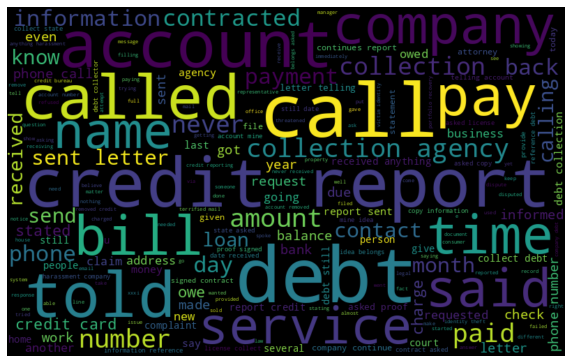

Consumer Loan


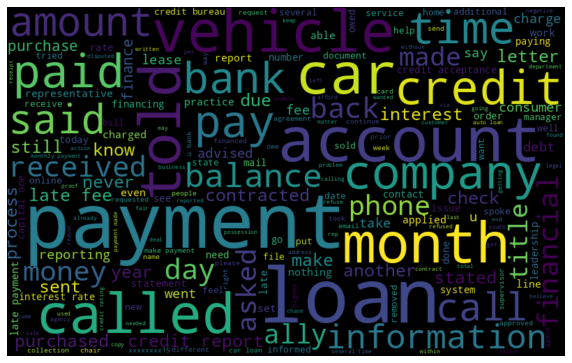

Mortgage


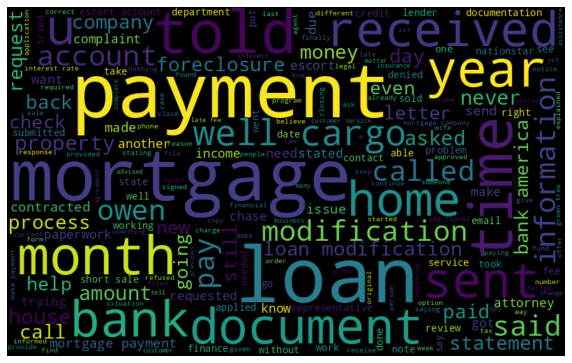

Credit card


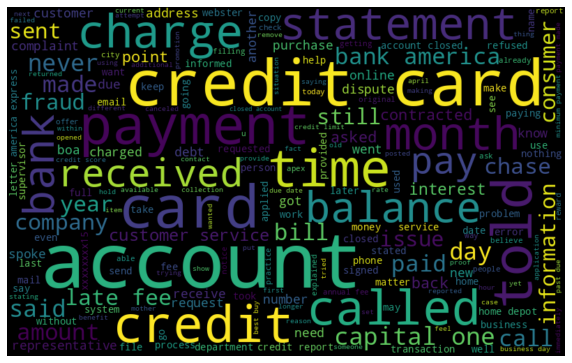

Credit reporting


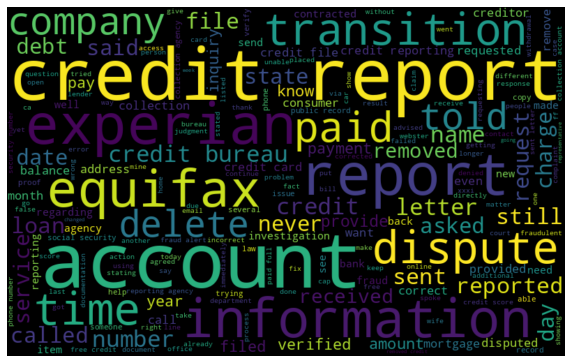

Student loan


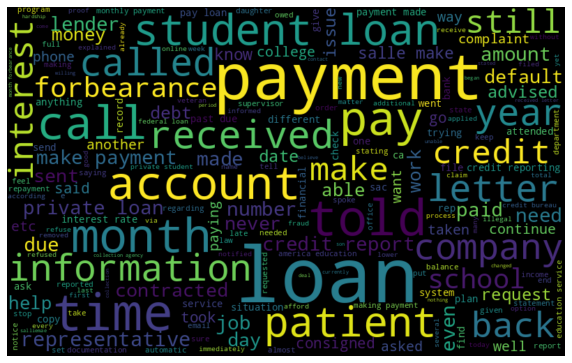

Bank account or service


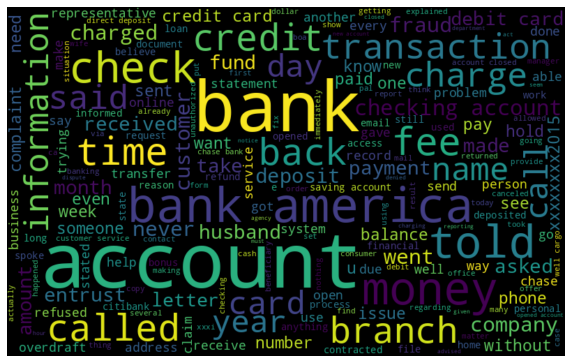

Payday loan


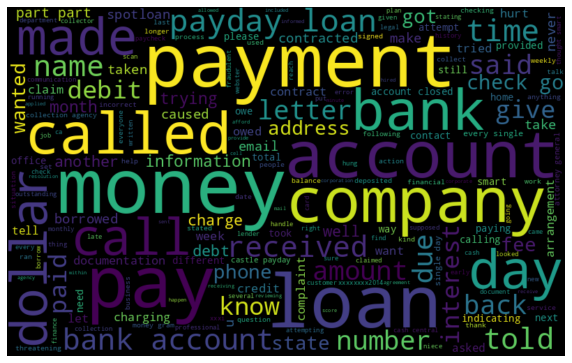

Money transfers


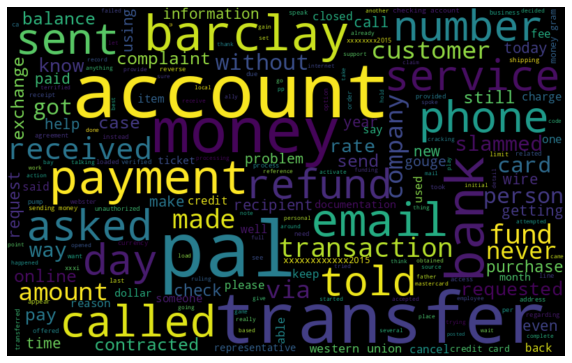

Other financial service


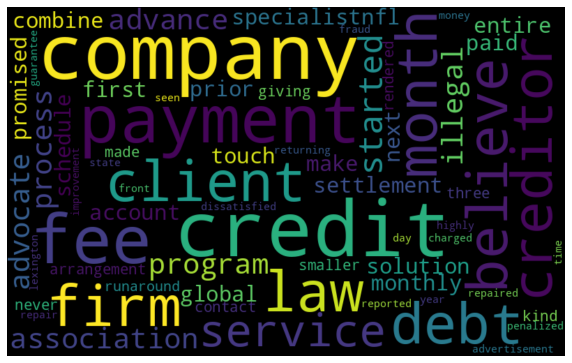

Prepaid card


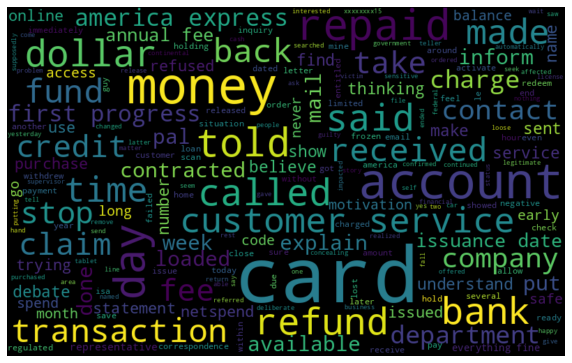

In [29]:
for product_name in df1['product'].unique():
    print(product_name)
    all_words = ' '.join([text for text in df1.loc[df1['product'].str.contains(product_name),'consumer_complaint_narrative']])
    
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


In [30]:
df1.shape

(2000, 12)

### Train/Test split


In [31]:
train_x, valid_x, train_y, valid_y = train_test_split(df1['consumer_complaint_narrative'], df1['product'],stratify=df1['product'], 
                                                    test_size=0.25)



Feature engineering of consumer complaint with TF-IDF

In [32]:

##label encoding target variable
enc = preprocessing.LabelEncoder()
train_y = enc.fit_transform(train_y)
valid_y = enc.fit_transform(valid_y)


In [33]:

##tf-idf verctor representation
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df1['consumer_complaint_narrative'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)


In [173]:
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
lr_params = {'C':[int(x) for x in np.linspace(1,10,10)]}
grid_lr = GridSearchCV(estimator=clf,param_grid=lr_params,cv=5,n_jobs=-1)
grid_lr.fit(xtrain_tfidf,train_y)


/Users/skasmani/opt/anaconda3/envs/AI_ML_38_GPU/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/skasmani/opt/anaconda3/envs/AI_ML_38_GPU/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

In [ ]:
# GridSearchCV(cv=5, error_score='raise-deprecating',
#        estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#           intercept_scaling=1, max_iter=100, multi_class='warn',
#           n_jobs=None, penalty='l2', random_state=None, solver='warn',
#           tol=0.0001, verbose=0, warm_start=False),
#        fit_params=None, iid='warn', n_jobs=-1,
#        param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
#        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#        scoring=None, verbose=0)


In [ ]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)


In [ ]:

final_lr = LogisticRegression(C=5)
final_lr.fit(xtrain_tfidf,train_y)


In [ ]:
LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [ ]:
final_lr_predict = final_lr.predict(xvalid_tfidf)
lr_accuracy = metrics.accuracy_score(final_lr_predict, valid_y)
print ("Logistic Regression > Accuracy: ", lr_accuracy)


In [65]:
from sklearn.metrics import classification_report


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, final_lr_predict,target_names=df1['product'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, final_lr_predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=df1['product'].unique(),yticklabels=df1['product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

We have acheived an accuracy of around 85% with a Logistic Regression model and the classification metrics are good for all departments except Payday loan - this might be due to less training instances of this product category and also on looking at the confusion matrix it is mostly being predicted as Credit reporting or debt collection which gives us an indication that this product is similar to one another or maybe linked with other.

We might further improve the performance using Random Forest, SVM, GBM, Neural Networks and utilize hyperparameter tuning.

### SVM

In [ ]:
from sklearn.svm import LinearSVC
svc_model = LinearSVC()
svc_params = {'C':[0.01,0.1, 1, 10, 100, 1000]}
grid_svc = GridSearchCV(estimator=svc_model,param_grid=svc_params,cv=5,n_jobs=-1)
grid_svc.fit(xtrain_tfidf,train_y)



In [ ]:
# GridSearchCV(cv=5, error_score='raise-deprecating',
#        estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#      verbose=0),
#        fit_params=None, iid='warn', n_jobs=-1,
#        param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
#        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#        scoring=None, verbose=0)


In [ ]:
print(grid_svc.best_params_)
print(grid_svc.best_score_)


In [ ]:

final_svc = LinearSVC(C=0.1)
final_svc.fit(xtrain_tfidf,train_y)


In [ ]:
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [ ]:
final_svc_predict = final_svc.predict(xvalid_tfidf)
svc_accuracy = metrics.accuracy_score(final_svc_predict, valid_y)
print ("SVC > Accuracy: ", svc_accuracy)


In [ ]:
print(classification_report(valid_y, final_svc_predict,target_names=df1['product'].unique()))

In [ ]:

conf_mat = confusion_matrix(valid_y, final_svc_predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=df1['product'].unique(),yticklabels=df1['product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### XGBOOST

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, eta=0.3, silent=1, subsample=0.8)
xgb_model.fit(xtrain_tfidf_final, train_y)



In [ ]:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=50, min_child_weight=1, missing=None,
       n_estimators=80, n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=0, reg_alpha=4, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=0.8)


In [ ]:
xgb_predict = xgb_model.predict(xvalid_tfidf_final)
xgb_accuracy = metrics.accuracy_score(xgb_predict, valid_y)
print ("XGBoost > Accuracy: ", xgb_accuracy)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, xgb_predict,target_names=df1['product'].unique()))


In [ ]:

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, xgb_predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=df1['product'].unique(),yticklabels=df1['product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Deep Learning models


In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Sequential


In [36]:

total_complaints = np.append(train_x.values,valid_x.values)
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(train_x.values)#total_complaints
train_sequences = tokenizer.texts_to_sequences(train_x.values)
test_sequences = tokenizer.texts_to_sequences(valid_x.values)


In [37]:

word_index = tokenizer.word_index# dictionary containing words and their index
print('Found %s unique tokens.' % len(word_index))


Found 7057 unique tokens.


In [90]:

MAX_SEQUENCE_LENGTH = max([len(c.split()) for c in total_complaints])
MAX_SEQUENCE_LENGTH


348

In [39]:

train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
print(train_data.shape)
print(test_data.shape)


(1500, 348)
(500, 348)


In [40]:

enc = preprocessing.LabelEncoder()
train_labels = enc.fit_transform(train_y)
test_labels = enc.fit_transform(valid_y)

print(enc.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))


[ 0  1  2  3  4  5  6  7  8  9 10]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([112,  84, 172, 227, 409,  20, 375,   2,  25,   9,  65]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 37,  28,  58,  76, 136,   7, 125,   1,   8,   3,  21]))


In [41]:

labels_train = to_categorical(np.asarray(train_labels))
labels_test = to_categorical(np.asarray(test_labels))
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', labels_train.shape)
print('Shape of label tensor:', labels_test.shape)


Shape of data tensor: (1500, 348)
Shape of label tensor: (1500, 11)
Shape of label tensor: (500, 11)



## CNN w/ Pre-trained word embeddings(GloVe)
We’ll use pre-trained embeddings such as Glove which provides word based vector representation trained on a large corpus.

It is trained on a dataset of one billion tokens (words) with a vocabulary of 400 thousand words. The glove has embedding vector sizes, including 50, 100, 200 and 300 dimensions.


In [72]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
GLOVE_DIR = '/Users/skasmani/Downloads/glove.6B/'
embeddings_index = {}
# f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))



Found 400000 word vectors.


Now lets create the embedding matrix using the word indexer created from tokenizer.


In [73]:

EMBEDDING_DIM = 50
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


Lets check the word embedded vector representation for token ‘loan’ in our embedding matrix


In [74]:


[(k,v) for k,v in word_index.items() if v==4]


[('loan', 4)]

In [75]:
embedding_matrix[4]  ## word embedded vector representation for token 'loan'

array([ 0.93484002,  0.40450999,  0.10856   , -0.61953998, -0.69220001,
        0.32119   , -0.70885003,  0.071233  , -0.33484   ,  0.77158999,
       -0.050077  ,  1.14460003,  0.01926   , -1.02590001,  0.85535002,
       -0.081615  ,  0.19649   , -0.051262  ,  0.40103999,  0.87255001,
        0.95371002, -0.87009001, -0.81568998, -0.24765   , -1.44400001,
       -0.88612998,  1.51440001, -0.014284  , -0.48023999, -0.32289001,
        3.00580001,  0.49408999,  0.72916001,  0.60891002,  0.59543997,
        0.49731001, -0.0057787 , -0.21278   ,  0.94937998, -2.16849995,
        0.12593   , -0.56818998,  0.50354999,  0.013716  , -1.01310003,
       -0.46805999,  0.17305   ,  1.62039995,  0.60404998,  0.063104  ])

In [76]:
vocab_size = len(tokenizer.word_index)+1


Now we load this embedding matrix into an Embedding layer using Sequential API to form a Convolutional NeuralNet model.
Dropout is applied between the hidden layers to factor regularization and prevent overfitting of neural network.



In [77]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
model.add(Dropout(0.3))
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(11, activation="softmax"))
model.compile(loss='categorical_crossentropy',
 optimizer="rmsprop",
 metrics=['acc'])


In [78]:
history = model.fit(train_data, labels_train,
 batch_size=64,
 epochs=50,
 validation_data=(test_data, labels_test))


Epoch 1/50
24/24 [==============================] - 2s 46ms/step - loss: 2.3280 - acc: 0.2767 - val_loss: 2.0246 - val_acc: 0.3820
Epoch 2/50
24/24 [==============================] - 1s 41ms/step - loss: 1.9692 - acc: 0.3260 - val_loss: 2.0406 - val_acc: 0.2940
Epoch 3/50
24/24 [==============================] - 1s 41ms/step - loss: 1.8462 - acc: 0.3820 - val_loss: 1.9223 - val_acc: 0.3480
Epoch 4/50
24/24 [==============================] - 1s 40ms/step - loss: 1.7071 - acc: 0.4220 - val_loss: 1.8733 - val_acc: 0.3500
Epoch 5/50
24/24 [==============================] - 1s 41ms/step - loss: 1.5965 - acc: 0.4600 - val_loss: 1.8397 - val_acc: 0.3260
Epoch 6/50
24/24 [==============================] - 1s 40ms/step - loss: 1.4424 - acc: 0.5160 - val_loss: 1.7280 - val_acc: 0.4100
Epoch 7/50
24/24 [==============================] - 1s 40ms/step - loss: 1.3634 - acc: 0.5467 - val_loss: 1.6352 - val_acc: 0.4200
Epoch 8/50
24/24 [==============================] - 1s 40ms/step - loss: 1.2811 - a

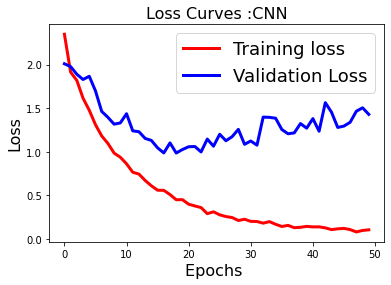

In [61]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
plt.show()

After 3 epochs the CNN tends to be overfitting the training data and therefore we need to implement early stopping to prevent such instances of overfitting and tune the number of epochs during training.



In [79]:
#predictions on test data
predicted=model.predict(test_data)
predicted

array([[2.5795198e-11, 6.3724116e-08, 3.6858390e-12, ..., 6.6185969e-14,
        7.3943691e-19, 5.1284543e-10],
       [4.9622119e-03, 2.7981780e-02, 5.4809963e-04, ..., 2.9708824e-01,
        2.1567552e-04, 2.1519923e-01],
       [7.6282242e-10, 3.1485672e-06, 2.6292550e-09, ..., 3.2117234e-10,
        3.0984604e-14, 1.4239960e-09],
       ...,
       [8.8276429e-06, 5.0529627e-05, 3.7700904e-03, ..., 1.9519559e-06,
        2.2146732e-08, 2.7516532e-07],
       [2.1687205e-04, 1.5297727e-01, 3.2659597e-04, ..., 1.3878465e-01,
        4.6614587e-06, 5.9753799e-01],
       [7.3913345e-04, 3.9866037e-04, 8.7784356e-06, ..., 1.5127798e-02,
        2.3247762e-06, 7.0743158e-04]], dtype=float32)

In [80]:
#model evaluation
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(labels_test, predicted.round())
print('precision: \n{}'.format(precision))
print('recall: \n{}'.format(recall))
print('fscore: \n{}'.format(fscore))
print('support: \n{}'.format(support))

precision: 
[0.63636364 0.64285714 0.42574257 0.81481481 0.825      0.14285714
 0.9537037  0.         0.16666667 0.         0.83333333]
recall: 
[0.37837838 0.32142857 0.74137931 0.57894737 0.72794118 0.14285714
 0.824      0.         0.125      0.         0.47619048]
fscore: 
[0.47457627 0.42857143 0.5408805  0.67692308 0.7734375  0.14285714
 0.88412017 0.         0.14285714 0.         0.60606061]
support: 
[ 37  28  58  76 136   7 125   1   8   3  21]


In [81]:
from sklearn.metrics import classification_report


In [82]:
print(classification_report(labels_test, predicted.round(),target_names=df1['product'].unique()))


                         precision    recall  f1-score   support

        Debt collection       0.64      0.38      0.47        37
          Consumer Loan       0.64      0.32      0.43        28
               Mortgage       0.43      0.74      0.54        58
            Credit card       0.81      0.58      0.68        76
       Credit reporting       0.82      0.73      0.77       136
           Student loan       0.14      0.14      0.14         7
Bank account or service       0.95      0.82      0.88       125
            Payday loan       0.00      0.00      0.00         1
        Money transfers       0.17      0.12      0.14         8
Other financial service       0.00      0.00      0.00         3
           Prepaid card       0.83      0.48      0.61        21

              micro avg       0.72      0.65      0.68       500
              macro avg       0.49      0.39      0.42       500
           weighted avg       0.76      0.65      0.69       500
            samples avg

Now, we’ll initialize our Embedding layer from scratch and learning its weights during training instead of using a pre-trained word embeddings and build a small 1D convnet to solve our classification problem.



In [83]:
#The Embedding layer requires the specification of the vocabulary size (vocab_size), 
#the size of the real-valued vector space EMBEDDING_DIM = 100,
#and the maximum length of input documents max_length .
vocab_size = len(tokenizer.word_index)+1
EMBEDDING_DIM = 50
max_length = 394

In [86]:
model = Sequential()
model.add(Embedding(vocab_size,
 50,
 input_length=MAX_SEQUENCE_LENGTH
 ))
model.add(Dropout(0.3))
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(11, activation="softmax"))
model.compile(loss='categorical_crossentropy',
 optimizer="rmsprop",
 metrics=['acc'])

In [89]:
history = model.fit(train_data, labels_train,
 batch_size=256,
 epochs=80,
 validation_data=(test_data, labels_test))

Epoch 1/80
6/6 [==============================] - 1s 167ms/step - loss: 0.0135 - acc: 0.9940 - val_loss: 2.3219 - val_acc: 0.6540
Epoch 2/80
6/6 [==============================] - 1s 157ms/step - loss: 0.0148 - acc: 0.9960 - val_loss: 2.0061 - val_acc: 0.6900
Epoch 3/80
6/6 [==============================] - 1s 161ms/step - loss: 0.0098 - acc: 0.9967 - val_loss: 2.2195 - val_acc: 0.6900
Epoch 4/80
6/6 [==============================] - 1s 154ms/step - loss: 0.0113 - acc: 0.9967 - val_loss: 2.4287 - val_acc: 0.6620
Epoch 5/80
6/6 [==============================] - 1s 156ms/step - loss: 0.0118 - acc: 0.9967 - val_loss: 2.0838 - val_acc: 0.6700
Epoch 6/80
6/6 [==============================] - 1s 160ms/step - loss: 0.0111 - acc: 0.9947 - val_loss: 2.2684 - val_acc: 0.6720
Epoch 7/80
6/6 [==============================] - 1s 155ms/step - loss: 0.0085 - acc: 0.9967 - val_loss: 1.9719 - val_acc: 0.6860
Epoch 8/80
6/6 [==============================] - 1s 161ms/step - loss: 0.0059 - acc: 0.99

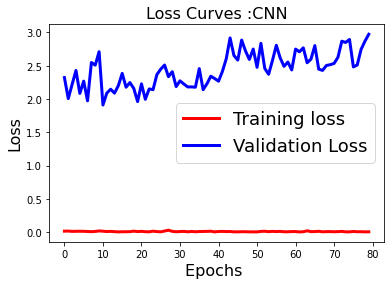

In [91]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
plt.show()

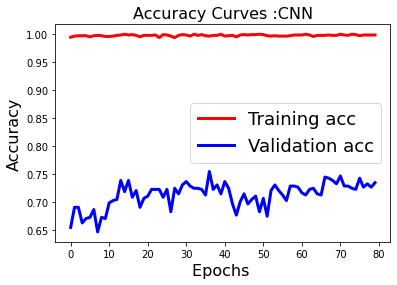

In [92]:
fig1 = plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training acc', 'Validation acc'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves :CNN',fontsize=16)
plt.show()

In [93]:
#predictions on test data
predicted=model.predict(test_data)
predicted

array([[2.47741426e-22, 1.53579303e-22, 1.12054741e-26, ...,
        9.90983524e-26, 2.08853138e-31, 2.25661616e-21],
       [2.42819365e-08, 4.72501461e-06, 2.53304810e-13, ...,
        1.53799884e-09, 1.01810018e-08, 9.61607043e-07],
       [4.22896750e-18, 1.80719773e-12, 8.89469575e-23, ...,
        5.32569833e-20, 3.81740492e-19, 9.31900460e-11],
       ...,
       [1.80613635e-21, 2.66187593e-12, 3.36413918e-11, ...,
        4.61743437e-19, 1.82022568e-21, 1.80227252e-13],
       [1.06040046e-14, 2.65526796e-05, 2.19426406e-13, ...,
        1.46810635e-05, 2.53537913e-10, 3.82316321e-01],
       [1.55993962e-06, 2.87425675e-04, 8.56790916e-10, ...,
        2.49180871e-08, 2.82930529e-07, 2.80651788e-04]], dtype=float32)

In [94]:
#model evaluation
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(labels_test, predicted.round())
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print("############################")
print(sklearn.metrics.classification_report(labels_test, predicted.round()))

precision: [0.94117647 0.6        0.58461538 0.66666667 0.6969697  0.66666667
 0.94017094 0.         0.         0.         0.70588235]
recall: [0.43243243 0.32142857 0.65517241 0.81578947 0.84558824 0.28571429
 0.88       0.         0.         0.         0.57142857]
fscore: [0.59259259 0.41860465 0.61788618 0.73372781 0.7641196  0.4
 0.90909091 0.         0.         0.         0.63157895]
support: [ 37  28  58  76 136   7 125   1   8   3  21]
############################
              precision    recall  f1-score   support

           0       0.94      0.43      0.59        37
           1       0.60      0.32      0.42        28
           2       0.58      0.66      0.62        58
           3       0.67      0.82      0.73        76
           4       0.70      0.85      0.76       136
           5       0.67      0.29      0.40         7
           6       0.94      0.88      0.91       125
           7       0.00      0.00      0.00         1
           8       0.00      0.00    

In [95]:
## RNN

In [97]:
#Bidirectional LSTM

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
model.add(Bidirectional(LSTM(100, dropout = 0.2)))
model.add(Dense(11,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])


In [105]:
history = model.fit(train_data, labels_train,
 batch_size=256,
 epochs=80,
 validation_data=(test_data, labels_test))

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Epoch 1/80
6/6 [==============================] - 4s 686ms/step - loss: 0.0687 - acc: 0.9833 - val_loss: 1.0342 - val_acc: 0.7500
Epoch 2/80
6/6 [==============================] - 4s 673ms/step - loss: 0.0600 - acc: 0.9847 - val_loss: 1.0331 - val_acc: 0.7420
Epoch 3/80
6/6 [==============================] - 4s 682ms/step - loss: 0.0675 - acc: 0.9793 - val_loss: 1.0369 - val_acc: 0.7540
Epoch 4/80
6/6 [==============================] - 4s 683ms/step - loss: 0.0561 - acc: 0.9853 - val_loss: 1.0421 - val_acc: 0.7460
Epoch 5/80
6/6 [==============================] - 4s 682ms/step - loss: 0.1214 - acc: 0.9633 - val_loss: 0.9750 - val_acc: 0.7600
Epoch 6/80
6/6 [==============================] - 4s 680ms/step - loss: 0.0594 - acc: 0.9867 - val_loss: 1.0405 - val_acc: 0.7360
Epoch 7/80
6/6 [==============================] - 4s 716ms/step - loss: 0.0465

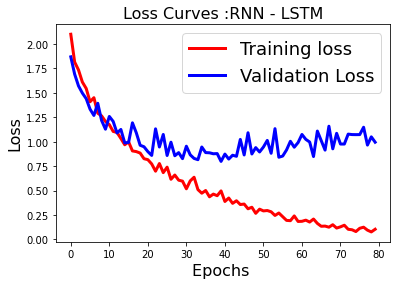

In [99]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN - LSTM',fontsize=16)
plt.show()

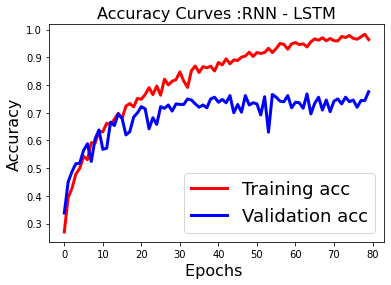

In [100]:
fig1 = plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training acc', 'Validation acc'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves :RNN - LSTM',fontsize=16)
plt.show()

In [101]:
#predictions on test data
predicted=model.predict(test_data)
predicted

array([[1.92765801e-05, 1.15075592e-04, 4.94623018e-05, ...,
        4.17350293e-06, 1.05029485e-05, 8.80963998e-05],
       [6.38954749e-04, 1.57608534e-03, 1.64167047e-03, ...,
        3.09936749e-03, 5.72222983e-04, 2.59881824e-01],
       [1.46197344e-04, 4.99563059e-04, 9.78472017e-05, ...,
        7.23066332e-05, 4.01263169e-05, 8.98802755e-05],
       ...,
       [9.15793993e-04, 1.85072329e-02, 5.77298505e-03, ...,
        2.09968872e-04, 3.86305677e-04, 1.13646791e-03],
       [7.92453589e-04, 1.20744608e-01, 4.77839785e-04, ...,
        5.98964095e-02, 2.20551810e-04, 1.90402105e-01],
       [3.94294875e-05, 8.05879463e-05, 2.44960102e-05, ...,
        6.88805449e-06, 1.36654289e-05, 1.38773263e-04]], dtype=float32)

In [102]:
#model evaluation
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(labels_test, predicted.round())
print('precision: \n{}'.format(precision))
print('recall: \n{}'.format(recall))
print('fscore: \n{}'.format(fscore))
print('support: \n{}'.format(support))
print("############################")

precision: 
[0.72727273 0.70833333 0.71111111 0.82352941 0.76       1.
 0.89230769 0.         0.66666667 0.         0.84615385]
recall: 
[0.86486486 0.60714286 0.55172414 0.73684211 0.83823529 0.14285714
 0.928      0.         0.25       0.         0.52380952]
fscore: 
[0.79012346 0.65384615 0.62135922 0.77777778 0.7972028  0.25
 0.90980392 0.         0.36363636 0.         0.64705882]
support: 
[ 37  28  58  76 136   7 125   1   8   3  21]
############################


In [103]:
print(classification_report(labels_test, predicted.round(),target_names=df1['product'].unique()))


                         precision    recall  f1-score   support

        Debt collection       0.73      0.86      0.79        37
          Consumer Loan       0.71      0.61      0.65        28
               Mortgage       0.71      0.55      0.62        58
            Credit card       0.82      0.74      0.78        76
       Credit reporting       0.76      0.84      0.80       136
           Student loan       1.00      0.14      0.25         7
Bank account or service       0.89      0.93      0.91       125
            Payday loan       0.00      0.00      0.00         1
        Money transfers       0.67      0.25      0.36         8
Other financial service       0.00      0.00      0.00         3
           Prepaid card       0.85      0.52      0.65        21

              micro avg       0.80      0.76      0.78       500
              macro avg       0.65      0.49      0.53       500
           weighted avg       0.79      0.76      0.77       500
            samples avg

After hours of training we get good results with LSTM(type of recurrent neural network) compared to CNN. From the learning curves it is clear the model needs to be tuned for overfitting by selecting hyperparameters such as no of epochs via early stopping and dropout for regularization.

We could further improve our final result by ensembling our xgboost and Neural network models by using Logistic Regression as our base model.



In [104]:
df1.to_csv(r'light_cc_data.csv')